In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings("ignore")

import xgboost as xgb
import lightgbm as lgb

from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, f1_score, precision_recall_curve

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
train.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0


In [3]:
print(train.shape)
print(test.shape)

(54808, 14)
(23490, 13)


In [4]:
train["is_promoted"].value_counts()

0    50140
1     4668
Name: is_promoted, dtype: int64

In [5]:
# Learning rate
print("Event rate in %: ", round((train["is_promoted"].value_counts()[1] * 100)/train.shape[0], 2))
# 8.52 - We may have to try SMOTE here. Lets see further

Event rate in %:  8.52


In [6]:
print(train.describe())

        employee_id  no_of_trainings           age  previous_year_rating  \
count  54808.000000     54808.000000  54808.000000          50684.000000   
mean   39195.830627         1.253011     34.803915              3.329256   
std    22586.581449         0.609264      7.660169              1.259993   
min        1.000000         1.000000     20.000000              1.000000   
25%    19669.750000         1.000000     29.000000              3.000000   
50%    39225.500000         1.000000     33.000000              3.000000   
75%    58730.500000         1.000000     39.000000              4.000000   
max    78298.000000        10.000000     60.000000              5.000000   

       length_of_service  KPIs_met >80%   awards_won?  avg_training_score  \
count       54808.000000   54808.000000  54808.000000        54808.000000   
mean            5.865512       0.351974      0.023172           63.386750   
std             4.265094       0.477590      0.150450           13.371559   
min    

In [7]:
all_data_na = (train.isnull().sum() / len(train)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:22]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data
# df_loan.dropna(axis=1,thresh=int(0.30*df_loan.shape[0]),inplace=True)

,Missing Ratio
previous_year_rating,7.524449
education,4.395344


In [8]:
print(train['education'].value_counts())
print(train['previous_year_rating'].value_counts())

Bachelor's          36669
Master's & above    14925
Below Secondary       805
Name: education, dtype: int64
3.0    18618
5.0    11741
4.0     9877
1.0     6223
2.0     4225
Name: previous_year_rating, dtype: int64


Replacing the missing values with the mode 

In [9]:
values = {"previous_year_rating":3, "education":"Bachelor's"}
train.fillna(value=values, inplace=True)

In [10]:
train.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0


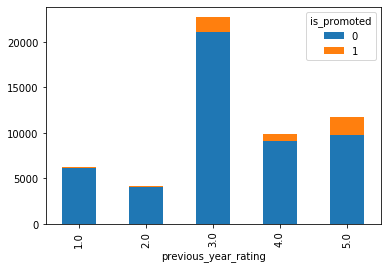

In [11]:
train.groupby("previous_year_rating")['is_promoted'].value_counts().unstack().plot(kind='bar',stacked=True)

We can infer that the Employee who got rating 5.0 in the previous year got promotion most oftenly

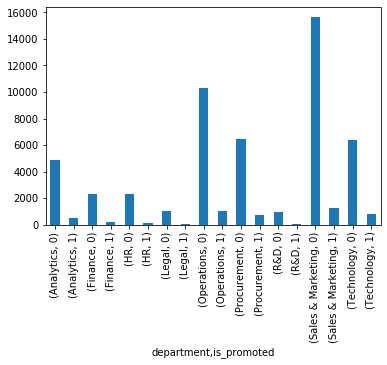

In [12]:
train.groupby("department")['is_promoted'].value_counts().plot(kind='bar',stacked=True)

Employees who belog to the department Sales and Marketing has higher chance to get promoted

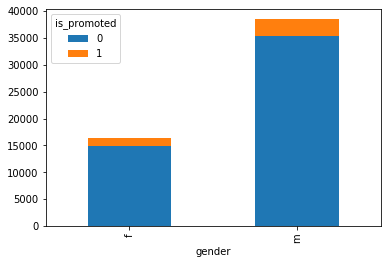

In [13]:
train.groupby("gender")['is_promoted'].value_counts().unstack().plot(kind='bar',stacked=True)

In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54808 entries, 0 to 54807
Data columns (total 14 columns):
employee_id             54808 non-null int64
department              54808 non-null object
region                  54808 non-null object
education               54808 non-null object
gender                  54808 non-null object
recruitment_channel     54808 non-null object
no_of_trainings         54808 non-null int64
age                     54808 non-null int64
previous_year_rating    54808 non-null float64
length_of_service       54808 non-null int64
KPIs_met >80%           54808 non-null int64
awards_won?             54808 non-null int64
avg_training_score      54808 non-null int64
is_promoted             54808 non-null int64
dtypes: float64(1), int64(8), object(5)
memory usage: 5.9+ MB


Mostly Male gender employees were got promotion

In [15]:
train.groupby("gender")['is_promoted'].value_counts()

gender  is_promoted
f       0              14845
        1               1467
m       0              35295
        1               3201
Name: is_promoted, dtype: int64

**Can we make some inferences from EDA ?** 

In [16]:
# EDA
for col in train.drop('is_promoted', axis=1).columns:
    if (train[col].dtype == 'object') or(train[col].dtype != 'object'):
        xx = train.groupby(col)['is_promoted'].value_counts().unstack()
        per_not_promoted = xx.iloc[:, 0] *100/xx.apply(lambda x: x.sum(), axis=1)
        per_promoted = xx.iloc[:, 1]*100/xx.apply(lambda x: x.sum(), axis=1)
        xx['%_0'] = round(per_not_promoted,2)
        xx['%_1'] = round(per_promoted,2)
        display(xx)

is_promoted,0,1,%_0,%_1
employee_id,,,,
1,1.0,NaN,100.0,NaN
2,1.0,NaN,100.0,NaN
4,1.0,NaN,100.0,NaN
5,1.0,NaN,100.0,NaN
7,1.0,NaN,100.0,NaN
...,...,...,...,...
78292,NaN,1.0,NaN,100.0
78294,1.0,NaN,100.0,NaN
78296,1.0,NaN,100.0,NaN


is_promoted,0,1,%_0,%_1
department,,,,
Analytics,4840,512,90.43,9.57
Finance,2330,206,91.88,8.12
HR,2282,136,94.38,5.62
Legal,986,53,94.90,5.10
Operations,10325,1023,90.99,9.01
Procurement,6450,688,90.36,9.64
R&D,930,69,93.09,6.91
Sales & Marketing,15627,1213,92.80,7.20
Technology,6370,768,89.24,10.76


is_promoted,0,1,%_0,%_1
region,,,,
region_1,552,58,90.49,9.51
region_10,597,51,92.13,7.87
region_11,1241,74,94.37,5.63
region_12,467,33,93.40,6.60
region_13,2418,230,91.31,8.69
...,...,...,...,...
region_5,731,35,95.43,4.57
region_6,658,32,95.36,4.64
region_7,4327,516,89.35,10.65


is_promoted,0,1,%_0,%_1
education,,,,
Bachelor's,35948,3130,91.99,8.01
Below Secondary,738,67,91.68,8.32
Master's & above,13454,1471,90.14,9.86


is_promoted,0,1,%_0,%_1
gender,,,,
f,14845,1467,91.01,8.99
m,35295,3201,91.68,8.32


is_promoted,0,1,%_0,%_1
recruitment_channel,,,,
other,27890,2556,91.60,8.40
referred,1004,138,87.92,12.08
sourcing,21246,1974,91.50,8.50


is_promoted,0,1,%_0,%_1
no_of_trainings,,,,
1,40468.0,3910.0,91.19,8.81
2,7382.0,605.0,92.43,7.57
3,1654.0,122.0,93.13,6.87
4,442.0,26.0,94.44,5.56
5,125.0,3.0,97.66,2.34
6,42.0,2.0,95.45,4.55
7,12.0,NaN,100.00,NaN
8,5.0,NaN,100.00,NaN
9,5.0,NaN,100.00,NaN


is_promoted,0,1,%_0,%_1
age,,,,
20,109,4,96.46,3.54
21,93,5,94.90,5.10
22,213,18,92.21,7.79
23,394,34,92.06,7.94
24,775,70,91.72,8.28
...,...,...,...,...
56,243,21,92.05,7.95
57,233,5,97.90,2.10
58,197,16,92.49,7.51


is_promoted,0,1,%_0,%_1
previous_year_rating,,,,
1.0,6135,88,98.59,1.41
2.0,4044,181,95.72,4.28
3.0,21048,1694,92.55,7.45
4.0,9093,784,92.06,7.94
5.0,9820,1921,83.64,16.36


is_promoted,0,1,%_0,%_1
length_of_service,,,,
1,4170.0,377.0,91.71,8.29
2,6089.0,595.0,91.10,8.90
3,6424.0,609.0,91.34,8.66
4,6238.0,598.0,91.25,8.75
5,5357.0,475.0,91.86,8.14
...,...,...,...,...
31,20.0,NaN,100.00,NaN
32,8.0,2.0,80.00,20.00
33,9.0,NaN,100.00,NaN


is_promoted,0,1,%_0,%_1
KPIs_met >80%,,,,
0,34111,1406,96.04,3.96
1,16029,3262,83.09,16.91


is_promoted,0,1,%_0,%_1
awards_won?,,,,
0,49429,4109,92.33,7.67
1,711,559,55.98,44.02


is_promoted,0,1,%_0,%_1
avg_training_score,,,,
39,2.0,NaN,100.00,NaN
40,5.0,NaN,100.00,NaN
41,25.0,1.0,96.15,3.85
42,60.0,2.0,96.77,3.23
43,169.0,7.0,96.02,3.98
...,...,...,...,...
95,NaN,45.0,NaN,100.00
96,1.0,47.0,2.08,97.92
97,NaN,49.0,NaN,100.00


**Explanation of the above code**  
1.We are taking each object or categorical column and grouping is done base on the promotion ,and for each column the percentage of promotion is added as extra column


Promotions are worst in Legal department (5.1%). Best promotions are in technology department (10.7%).  
Region 9 is worst (1.9%) and region 7 is best (10.65%) in terms of promotions.  
Although Master’s & above has greater promotion percentage but difference is not much.  
Employees belonging to Female(8.99%) gender will have better chances of promotion than Males(8.32%).  
Employess who have been referred through recruitment channel has good chances of promotions (12.08%).  

In [17]:
# Convert categorical to dummies
def convert_categorical_to_dummies(df):
    list_to_drop = []
    for col in df.columns:
        if df[col].dtype == 'object':
            print("Converting....", col)
            list_to_drop.append(col)
            df = pd.concat([df, pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True)], axis=1)
    return df, list_to_drop

In the above code we are checking for object data type and doing its dummy and then drooping the same variable by dropping the variable which been been made dummy

In [18]:
# Convert data to dummy variables
processed_data, list_to_drop = convert_categorical_to_dummies(train)
print("Total shape of Data :", processed_data.shape)
print("Columns which need to be dropped :", list_to_drop)
processed_data = processed_data.drop(list_to_drop, axis = 1)
print("Total shape of Data :", processed_data.shape)

train_xs = processed_data.drop(['employee_id',"is_promoted"],axis=1)
labels = train["is_promoted"]

Converting.... department
Converting.... region
Converting.... education
Converting.... gender
Converting.... recruitment_channel
Total shape of Data : (54808, 60)
Columns which need to be dropped : ['department', 'region', 'education', 'gender', 'recruitment_channel']
Total shape of Data : (54808, 55)


# Model Building

In [19]:
#  Create parameters to search
params = {
     'learning_rate': [0.01],#learning rate
     'n_estimators': [900, 1000, 1100],# no. of trees
     'max_depth':[7,8,9],
     'reg_alpha':[0.3, 0.4, 0.5] # regularization alpha(lasso)
    }
 
# Initializing the XGBoost Regressor
xgb_model = xgb.XGBClassifier()
 
# Gridsearch initializaation
gsearch = RandomizedSearchCV(xgb_model, params,
                    verbose=True,
                    cv=3,
                    n_jobs=-1)
 
gsearch.fit(train_xs, labels)
 
#Printing the best chosen params
print("Best Parameters :",gsearch.best_params_)
 
params = {'objective':'binary:logistic', 'booster':'gbtree'}
 
# Updating the parameter as per grid search
params.update(gsearch.best_params_)


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 40.2min finished


Best Parameters : {'reg_alpha': 0.5, 'n_estimators': 900, 'max_depth': 8, 'learning_rate': 0.01}


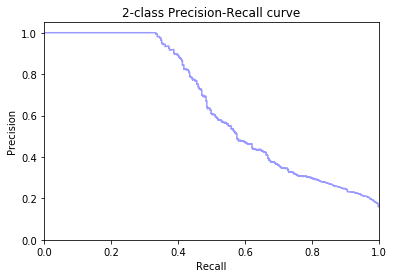

In [20]:
# Splitting the dataset in order to use early stopping round
X_train, X_test, y_train, y_test = train_test_split(train_xs, labels, test_size=0.10, stratify=labels)
xgb_model = xgb.XGBClassifier(**params)

# Training the models
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict_proba(X_test)
precision, recall, thresholds = precision_recall_curve(y_test, y_pred[:,1])
thresholds = np.append(thresholds, 1)

f1_scores = 2*(precision*recall)/(precision+recall)
plt.step(recall, precision, color='b', alpha=0.4, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve')
plt.show()

Threshold cutoff:  0.2952645421028137
Max F1-score at cut-off :  0.5725806451612903


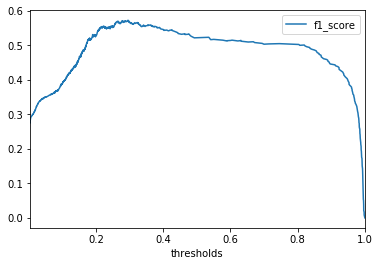

In [21]:
scrs = pd.DataFrame({'precision' : precision, 'recal' : recall, 'thresholds' : thresholds, 'f1_score':f1_scores})
print("Threshold cutoff: ",scrs.loc[scrs['f1_score'] == scrs.f1_score.max(),'thresholds'].iloc[0])
print("Max F1-score at cut-off : ",scrs.f1_score.max())
scrs.plot(x='thresholds', y='f1_score')

In [22]:
# Create submission file
test = pd.read_csv("test.csv")
# Missing treatment
values = {"previous_year_rating":3, "education":"Bachelor's"}
test.fillna(value=values, inplace=True)

# Convert data to dummy variables
processed_data, list_to_drop = convert_categorical_to_dummies(test)
print("Total shape of Data :", processed_data.shape)
print("Columns which need to be dropped :", list_to_drop)
processed_data = processed_data.drop(list_to_drop, axis = 1)
print("Total shape of Data :", processed_data.shape)

# Removing the id attributes
test_data = processed_data.drop(['employee_id'],axis=1)
y_pred = xgb_model.predict_proba(test_data)

Converting.... department
Converting.... region
Converting.... education
Converting.... gender
Converting.... recruitment_channel
Total shape of Data : (23490, 59)
Columns which need to be dropped : ['department', 'region', 'education', 'gender', 'recruitment_channel']
Total shape of Data : (23490, 54)


# Best model as of now

In [23]:
#predictions = (y_pred[:,1] >= scrs.f1_score.max()).astype("int") # 0.47025495750708224.
#predictions = (y_pred[:,1] >= 0.340377241373).astype("int") # 0.4876760563380282 
predictions = (y_pred[:,1] >= 0.24252495169639587).astype("int") # 0.5158371040723982.
submission_df = pd.DataFrame({'employee_id':test['employee_id'],'is_promoted':predictions})
submission_df.to_csv("XGB_tuned_model_1.csv", index=False)

In [24]:
# Try lightgbm
# Initializing the LightGBM model
gbm_model = lgb.LGBMClassifier(objective='binary')

# Cross validation score 
f1_scores = cross_val_score(gbm_model, train_xs, labels, cv=5, scoring='f1',n_jobs=-1)
print(f1_scores," Mean = ",np.mean(f1_scores))

# Splitting the dataset in order to use early stopping round
X_train, X_test, y_train, y_test = train_test_split(train_xs, labels, test_size=0.10, stratify=labels)

# Fitting LightGBM model
gbm_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric='auc', early_stopping_rounds=150)

[0.515625   0.48584906 0.49724626 0.53137103 0.50078247]  Mean =  0.5061747644423162
[1]	valid_0's auc: 0.857222	valid_0's binary_logloss: 0.264506
Training until validation scores don't improve for 150 rounds
[2]	valid_0's auc: 0.889576	valid_0's binary_logloss: 0.24709
[3]	valid_0's auc: 0.891017	valid_0's binary_logloss: 0.235655
[4]	valid_0's auc: 0.895642	valid_0's binary_logloss: 0.226336
[5]	valid_0's auc: 0.896219	valid_0's binary_logloss: 0.218733
[6]	valid_0's auc: 0.897752	valid_0's binary_logloss: 0.212206
[7]	valid_0's auc: 0.899631	valid_0's binary_logloss: 0.20674
[8]	valid_0's auc: 0.900596	valid_0's binary_logloss: 0.202072
[9]	valid_0's auc: 0.899904	valid_0's binary_logloss: 0.19808
[10]	valid_0's auc: 0.900431	valid_0's binary_logloss: 0.194254
[11]	valid_0's auc: 0.9007	valid_0's binary_logloss: 0.190988
[12]	valid_0's auc: 0.901769	valid_0's binary_logloss: 0.188011
[13]	valid_0's auc: 0.902432	valid_0's binary_logloss: 0.185625
[14]	valid_0's auc: 0.904169	valid_

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective='binary',
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [25]:
# Create submission file
test = pd.read_csv("test.csv")
# Missing treatment
values = {"previous_year_rating":3, "education":"Bachelor's"}
test.fillna(value=values, inplace=True)

# Convert data to dummy variables
processed_data, list_to_drop = convert_categorical_to_dummies(test)
print("Total shape of Data :", processed_data.shape)
print("Columns which need to be dropped :", list_to_drop)
processed_data = processed_data.drop(list_to_drop, axis = 1)
print("Total shape of Data :", processed_data.shape)

# Removing the id attributes
test_data = processed_data.drop(['employee_id'],axis=1)
y_pred = gbm_model.predict_proba(test_data, num_iteration=gbm_model.best_iteration_)

Converting.... department
Converting.... region
Converting.... education
Converting.... gender
Converting.... recruitment_channel
Total shape of Data : (23490, 59)
Columns which need to be dropped : ['department', 'region', 'education', 'gender', 'recruitment_channel']
Total shape of Data : (23490, 54)


In [26]:
predictions = (y_pred[:,1] >= 0.24252495169639587).astype("int") # 0.4996009577015163
submission_df = pd.DataFrame({'employee_id':test['employee_id'],'is_promoted':predictions})
submission_df.to_csv("lgbm_model_2.csv", index=False) 

In [27]:
ratio = float(np.sum(labels == 0)) / np.sum(labels==1)
print(ratio)

10.741216795201371


In [28]:
# No Improvement. Lets try SMOTE

from imblearn.over_sampling import SMOTE

print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))

sm = SMOTE(random_state=2)
X_train_res, y_train_res = sm.fit_sample(train_xs, labels.ravel())

print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train_res==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res==0)))

Using TensorFlow backend.


Before OverSampling, counts of label '1': 4201
Before OverSampling, counts of label '0': 45126 

After OverSampling, the shape of train_X: (100280, 53)
After OverSampling, the shape of train_y: (100280,) 

After OverSampling, counts of label '1': 50140
After OverSampling, counts of label '0': 50140


In [29]:
# Create parameters to search
params = {
     'learning_rate': [0.01],
     'n_estimators': [800, 900, 1000, 1100],
     'max_depth':[5, 6, 7, 8, 9],
     'reg_alpha':[0.2, 0.3, 0.4, 0.5, 0.6]
    }
 
# Initializing the XGBoost Regressor
xgb_model = xgb.XGBClassifier()
 
# Gridsearch initializaation
gsearch = RandomizedSearchCV(xgb_model, params,
                    verbose=True,
                    cv=3,
                    n_jobs=-1)
 
gsearch.fit(train_xs, labels)
 
#Printing the best chosen params
print("Best Parameters :",gsearch.best_params_)
 
params = {'objective':'binary:logistic', 'booster':'gbtree'}
 
# Updating the parameter as per grid search
params.update(gsearch.best_params_)
 
# Initializing the XGBoost Regressor
xgb_model = xgb.XGBClassifier(**params)
print(xgb_model)
 
# Cross validation scores
f1_scores = cross_val_score(xgb_model, train_xs, labels, cv=5, scoring='f1',n_jobs=-1)
print("F1_scores per fold : ",f1_scores," \nMean F1_score= ", np.mean(f1_scores))
 
# Fitting model on tuned parameters
xgb_model.fit(X_train_res, y_train_res)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 29.7min finished


Best Parameters : {'reg_alpha': 0.4, 'n_estimators': 800, 'max_depth': 8, 'learning_rate': 0.01}
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=None, n_estimators=800, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0.4, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)
F1_scores per fold :  [0.50471698 0.47468354 0.49328063 0.51921569 0.5015625 ]  
Mean F1_score=  0.49869186882429


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=None, n_estimators=800, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0.4, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

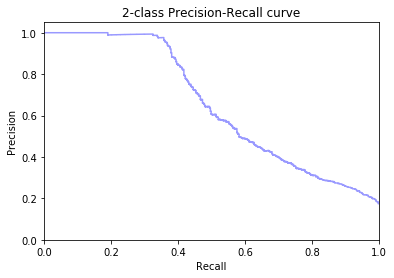

In [30]:
# Splitting the dataset in order to use early stopping round
X_train, X_test, y_train, y_test = train_test_split(train_xs, labels, test_size=0.10, stratify=labels)
xgb_model = xgb.XGBClassifier(**params)

# Training the models
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict_proba(X_test)

precision, recall, thresholds = precision_recall_curve(y_test, y_pred[:,1])
thresholds = np.append(thresholds, 1)
f1_scores = 2*(precision*recall)/(precision+recall)
plt.step(recall, precision, color='b', alpha=0.4, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve')
plt.show()

Threshold cutoff:  0.2091694325208664
Max F1-score at cut-off :  0.5608695652173913
Converting.... department
Converting.... region
Converting.... education
Converting.... gender
Converting.... recruitment_channel
Total shape of Data : (23490, 59)
Columns which need to be dropped : ['department', 'region', 'education', 'gender', 'recruitment_channel']
Total shape of Data : (23490, 54)


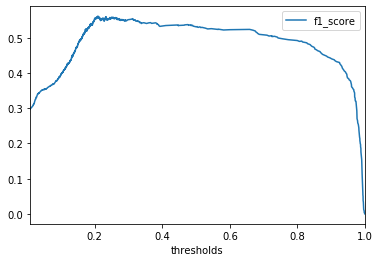

In [31]:
scrs = pd.DataFrame({'precision' : precision, 'recal' : recall, 'thresholds' : thresholds, 'f1_score':f1_scores})
print("Threshold cutoff: ",scrs.loc[scrs['f1_score'] == scrs.f1_score.max(),'thresholds'].iloc[0])
print("Max F1-score at cut-off : ",scrs.f1_score.max())
scrs.plot(x='thresholds', y='f1_score')

# Create submission file
test = pd.read_csv("test.csv")
# Missing treatment
values = {"previous_year_rating":3, "education":"Bachelor's"}
test.fillna(value=values, inplace=True)

# Convert data to dummy variables
processed_data, list_to_drop = convert_categorical_to_dummies(test)
print("Total shape of Data :", processed_data.shape)
print("Columns which need to be dropped :", list_to_drop)
processed_data = processed_data.drop(list_to_drop, axis = 1)
print("Total shape of Data :", processed_data.shape)

# Removing the id attributes
test_data = processed_data.drop(['employee_id'],axis=1)
y_pred = xgb_model.predict_proba(test_data)

In [32]:
predictions = (y_pred[:,1] >= 0.30655303597450256).astype("int") # 0.4995722840034217.
submission_df = pd.DataFrame({'employee_id':test['employee_id'],'is_promoted':predictions})
submission_df.to_csv("smote_xgb_weightfactor.csv", index=False) 